# Homework: Week 4

In this homework, we will use Credit Card Data from book "Econometric Analysis".

Here's a wget-able [link](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv):

```bash
wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv
```

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import wget

from sklearn.metrics import accuracy_score, auc, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

url = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv'
file = Path(url.rsplit('/')[-1])

if not file.exists():
    wget.download(url)

In [2]:
df = pd.read_csv(file.name)
df.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


## Preparation

* Create the target variable by mapping `yes` to 1 and `no` to 0. 
* Split the dataset into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` funciton for that with `random_state=1`.

In [3]:
df.card = (df.card == 'yes').astype(int)

In [4]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.card.values
y_val = df_val.card.values
y_test = df_test.card.values

del df_train['card']
del df_val['card']
del df_test['card']

## Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the `card` variable.
* Use the training dataset for that.

If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['expenditure']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

In [5]:
roc_auc_columns = ['reports', 'dependents', 'active', 'share']
auc_scores = {}

for column in roc_auc_columns:
    roc_auc = roc_auc_score(y_train, df_train[column])
    if roc_auc < 0.5:
        roc_auc = roc_auc_score(y_train, -df_train[column])
    auc_scores[column] = roc_auc

display(auc_scores)

{'reports': 0.7166629860689376,
 'dependents': 0.5327757227773791,
 'active': 0.6043173411362006,
 'share': 0.989183643423692}

Which numerical variable (among the following 4) has the highest AUC?

- `reports`
- `dependents`
- `active`
- **`share`**

## Training the model

From now on, use these columns only:

```
["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]
```

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 791 entries, 0 to 790
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   reports      791 non-null    int64  
 1   age          791 non-null    float64
 2   income       791 non-null    float64
 3   share        791 non-null    float64
 4   expenditure  791 non-null    float64
 5   owner        791 non-null    object 
 6   selfemp      791 non-null    object 
 7   dependents   791 non-null    int64  
 8   months       791 non-null    int64  
 9   majorcards   791 non-null    int64  
 10  active       791 non-null    int64  
dtypes: float64(4), int64(5), object(2)
memory usage: 68.1+ KB


In [7]:
categorical = ['owner', 'selfemp']
numerical = ['reports', 'age', 'income', 'share', 'expenditure', 'dependents', 'months', 'majorcards', 'active']
columns = numerical + categorical

In [8]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[columns].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1_000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

In [9]:
val_dict = df_val[numerical + categorical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]

round(roc_auc_score(y_val, y_pred), 3)

0.995

- 0.615
- 0.515
- 0.715
- **0.995**

## Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

In [10]:
pr_scores = []

thresholds = np.linspace(0, 1, 101)
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

for t in thresholds:    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    pr_scores.append((t, tp, fp, fn, tn))

columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(pr_scores, columns=columns)

df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['auc'] = auc(df_scores.fpr, df_scores.tpr)
df_scores.head()

,threshold,tp,fp,fn,tn,tpr,fpr,p,r,auc
0,0.00,211,53,0,0,1.0,1.000000,0.799242,1.0,0.994992
1,0.01,211,34,0,19,1.0,0.641509,0.861224,1.0,0.994992
2,0.02,211,31,0,22,1.0,0.584906,0.871901,1.0,0.994992
3,0.03,211,24,0,29,1.0,0.452830,0.897872,1.0,0.994992
4,0.04,211,22,0,31,1.0,0.415094,0.905579,1.0,0.994992


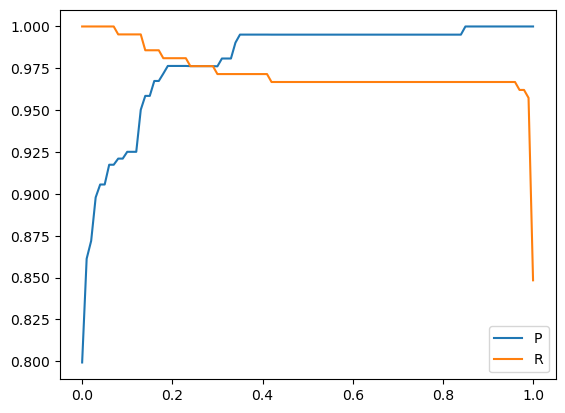

In [11]:
plt.plot(df_scores.threshold, df_scores.p, label='P')
plt.plot(df_scores.threshold, df_scores.r, label='R')
plt.legend()
plt.show()

At which threshold precision and recall curves intersect?

* 0.1
* **0.3**
* 0.6
* 0.8

## Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

F1 = 2 * P * R / (P + R)

Where P is precision and R is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

In [12]:
df_scores['f1_score'] = 2 * ((df_scores.p * df_scores.r) / (df_scores.p + df_scores.r))
df_scores[df_scores.f1_score == df_scores.f1_score.max()].threshold.mean()

0.38

At which threshold F1 is maximal?

- 0.1
- **0.4**
- 0.6
- 0.7

## Question 5

Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

In [13]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1_000)
    model.fit(X_train, y_train)
    
    return dv, model


def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [14]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.card.values
    y_val = df_val.card.values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print(f'{np.mean(scores):.3f} +- {np.std(scores):.3f}')

0.996 +- 0.003


How large is standard devidation of the AUC scores across different folds?

- **0.003**
- 0.014
- 0.09
- 0.24

## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

In [15]:
from tqdm.auto import tqdm

for C in tqdm([0.01, 0.1, 1, 10]):
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.card.values
        y_val = df_val.card.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print(f'C={C:<5} {np.mean(scores):.3f} +- {np.std(scores):.3f}')

  0%|          | 0/4 [00:00<?, ?it/s]

C=0.01  0.992 +- 0.006
C=0.1   0.995 +- 0.004
C=1     0.996 +- 0.003
C=10    0.996 +- 0.003


Which C leads to the best mean score?

- 0.01
- 0.1
- **1**
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C